# SOFIA/FORCAST Galactic Center Combine Fields Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [1]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, Table
from astropy.coordinates import SkyCoord, search_around_sky, Angle

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [2]:
#new functions needed for this notebook
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion

In [3]:
#import configuration for selected file
#from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *

In [4]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

In [13]:
def CombineFieldResults(CatName,wavelength): # #Name options- 'CombCat', 'SegCat', 'DaoCat'
    #pick a field to start with so we can get the table structure. 
    #The files for the field cannot be empty or an error message will display
    startfield=FieldA.name

    if os.path.exists(startfield+'_'+str(wavelength)+'um_'+CatName+'.fits'):
        cat=Table.read(startfield+'_'+str(wavelength)+'um_'+CatName+'.fits')

        #fix for issue with combining tables with objects as columns
        cat['RA(J2000)']=cat['sky_centroid'].ra
        cat['DEC(J2000)']=cat['sky_centroid'].dec
        cat['glon']=cat['sky_centroid'].galactic.l.deg
        cat['glat']=cat['sky_centroid'].galactic.b.deg
        cat.remove_column('sky_centroid')

    else:
        print('Error... Must pick another file to start with')
        
        
    #loop through all the saved photometry tables for individual fields and append them together
    for info in field._registry:
        filename=info.filename
        name=info.name

        #print('\nLoading in photometry data from field: ', name)

        if name is not startfield:

            if os.path.exists(name+'_'+str(wavelength)+'um_'+CatName+'.fits'):
                newtab1=Table.read(name+'_'+str(wavelength)+'um_'+CatName+'.fits')

                #fix for issue with combining tables with objects as columns
                newtab1['RA(J2000)']=newtab1['sky_centroid'].ra
                newtab1['DEC(J2000)']=newtab1['sky_centroid'].dec
                newtab1['glon']=newtab1['sky_centroid'].galactic.l.deg
                newtab1['glat']=newtab1['sky_centroid'].galactic.b.deg
                newtab1.remove_column('sky_centroid')

                #combine tables
                cat=vstack([cat,newtab1])


    #print the table sizes to get source counts
    #print('Raw number of combinded sources: ', len(cat))
    
    #sort table entries by gal. lat. 
    cat.sort('glon')
    
    #fix to wrap galactic coordinates
    alttabidx2=cat['glon']>180
    alttabidx1=cat['glon']<180
    c1=cat[alttabidx2]
    c2=cat[alttabidx1]
    catnew=vstack([c1,c2])
    
    #rename field based id to anothter name to avoid confusion
    #catnew.rename_column('id', 'old_id')
    
    #remove source 'id' values because they are field based and not useful in combined table
    catnew.remove_column('id')

    #add new ids to the master catalog
    #catnew['id']=np.linspace(1,len(catnew),len(catnew),dtype=np.int64)
    
    #re-add "sky_centroid" column 
    catnew['sky_centroid']=SkyCoord(catnew['RA(J2000)'],catnew['DEC(J2000)'],unit=u.deg)

    #return combined catalog
    return catnew
    

In [14]:
#source coords should be skycoord objects, sep should be an angular quantity e.g., 4*u.arcsec
def remove_duplicates(cat, sep):
	sourcecoords=cat['sky_centroid']

	#create KD Tree
	kdt=_get_cartesian_kdtree(sourcecoords)
    
	#search radius
	r = (2 * np.sin(Angle(sep) / 2.0)).value #search radius
    
	#initialize counter
	counter=0
    
	#create array to hold matches
	matchstore=np.zeros(len(cat),dtype=np.int)
    
	#loop through and find all matching sources within crossmatch radius
	for i, matches in enumerate(kdt.query_ball_tree(kdt,r)):
		if len(matches)>1:
			counter+=1
			
			for match in matches:
				if match!=matches[(match+1)%len(matches)]:
					matchstore[match]=matches[(match+1)%len(matches)]+1
				else:
					matchstore[match]=matches[(match+2)%len(matches)]+1

	#store possible crossmatches
	cat['selfXmatch']=matchstore
	print('number of likely duplicates: ', counter)
    
	#create keep and remove lists
	keep=[]
	remove=[]
    
	#loop through and mark sources to keep and remove based on which has the greater aperture photometry snr
	for row in cat:
		if row['selfXmatch']>0:
			#print(row['Master_id'])
			idx1 = row['id']
			idx2 = row['selfXmatch']
			
			row1=cat[cat['id']==idx1]
			row2=cat[cat['id']==idx2]
			
			snr1=row1['aper_snr_4pix'].data[0]
			snr2=row2['aper_snr_4pix'].data[0]
			           
			if snr1>snr2:
				keep.append(idx1)
				remove.append(idx2)
			else:
				keep.append(idx2)
				remove.append(idx1)

	#remove duplicates in lists
	keep=list(set(keep))
	remove=list(set(remove))
    
	#remove duplicates in table
	removeIdx=np.array(remove)-1 #fix zero/one initialization issue
	cat.remove_rows(removeIdx)
	
	return cat

In [15]:
def makeDS9file(savename, table, radius, color='green', labelon=False,label='ColumnName'):
    scs=table['sky_centroid']
    
    decimals = 1 # number of decimal places to display with labels
    
    #loop through and create region instances for each source
    regions=[]
    for i in range(0,len(scs)):
        region = CircleSkyRegion(scs[i], radius)
        regions.append(region)
            #write out region file
    write_ds9(regions, savename)
    
    hld=""
    with open(savename, 'r+') as f:
        lineno=0
        for line in f:
            if lineno<len(table):
                if labelon:
                    text=line.replace(r')', r') # color='+color+' text={'+str(np.round(table[label][lineno-2],decimals))+'}')
                else:
                    text=line.replace(r')', r') # color='+color)
                hld=hld+text
                lineno=lineno+1
        f.seek(0)
        f.write(hld)
        f.truncate()

In [16]:
#find the 'not' indcies for sources in table
def findNOTindex(tab,index):
    allpos=np.linspace(0,len(tab)-1,len(tab),dtype=np.int64) 
    notindex=list(set(allpos)-set(index))
    return notindex

In [17]:
#create catalog names for sources based on galactic coords
def createNames(tab):
    #get lat and long values
    latvals=tab['glat'].value
    lonvals=tab['glon'].value
    #convert to strings
    strings1 = ["%.4f" % lonvals for lonvals in lonvals]
    strings2 = ["%.4f" % latvals for latvals in latvals]
    #update string 2 to include '+' signs where needed
    s2update=[]
    for string in strings2:
        if not string.startswith('-'):
            string='+'+string
        s2update.append(string)
    #create names array
    names=['SFGC'+strings1+s2update for strings1,s2update in zip(strings1,s2update)]
    #add names to table
    tab['SourceID']=names
    #return table with names added
    return tab

## Combine data files for each field at 25 um

In [18]:
#create initial master catalog at 25 um
mastercat25=CombineFieldResults('CombCat',25)

#add names to mastercat
mastercat25=createNames(mastercat25)

#print the master catalog
mastercat25

type,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_5pix,aperture_sum_err_5pix,aperture_sum_6pix,aperture_sum_err_6pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_9pix,aperture_sum_err_9pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_5pix,aper_snr_5pix,aper_area_5pix,aper_sum_bkgsub_6pix,aper_snr_6pix,aper_area_6pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_9pix,aper_snr_9pix,aper_area_9pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,RA(J2000),DEC(J2000),glon,glat,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,deg,deg,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,str19
210,250.2257166121639,74.97958925726155,"266.0950436382803,-29.535024921422615",1.845885481333474,0.08444821973141009,2.570779911805536,0.10606378904109745,3.3183545166879505,0.12821244534513332,4.032149019661047,0.1510148301208088,4.7177463364214836,0.1745263053700836,5.379825919397939,0.1986665282506168,5.970770166395662,0.2231488547385178,6.850228539319838,0.27466261002762604,842.3890001756049,0.0003803196811617027,0.0007069918155229804,0.008085258790582747,297.2008361816406,243.62550801180805,1.825861911585917,26.004304584073665,52.649312510975314,2.539493084074978,37.64404044341836,82.26455079839893,3.2733014847559474,49.69398640091326,118.46095314969445,3.970826837309154,61.01653405794673,161.23851956486192,4.637652057431255,71.72369419795315,210.59725004390125,5.278456597550932,81.91009451531013,266.5371445868125,5.84562285547343,90.62500844663205,329.0582031935957,6.670016411591826,101.85724497534935,473.8438125987778,Field1,25,4.251548043528698,3.8351015095079495,5.699915199622362,2.4489997533779095,2.391723647932382,-22.59752088875347,266.0950436382803,-29.535024921422615,359.3480412690212,-0.08202059155827685,"266.0950436382803,-29.535024921422615",SFGC359.3480-0.0820
220,235.8129364732463,68.41343072864075,"266.09857748631543,-29.53642593639456",0.12248755178416385,0.0810017229680591,0.09654104310027684,0.10118385959690923,0.12597723150436402,0.12135081937907281,0.18682210570421204,0.1413548250945445,0.2997225801037092,0.16133376393736912,0.4128750543170273,0.18150203578085058,0.5635759337751979,0.20189950862451195,0.984090762340672,0.2434417230814924,842.3890001756049,-3.058263334552386e-07,0.0006026735039549028,0.01145437846204429,332.1656188964844,279.1724233990169,0.12250365333036801,0.13045083693217835,52.649312510975314,0.09656620176622084,0.06491249911784965,82.26455079839893,0.1260134599833234,0.09210382495940947,118.46095314969445,0.1868714166894623,0.17352879238253877,161.23851956486192,0.2997869862885259,0.39028553180576875,210.59725004390125,0.4129565683946859,0.6574612460191204,266.5371445868125,0.563676568438974,1.1003637824290948,329.0582031935957,0.9842356762565095,2.778273238405255,473.8438125987778,Field1,25,4.937649212924471,3.967248852323289,5.103407714444976,2.2319260053806214,2.1005169708144433,-43.614803433234016,266.09857748631543,-29.53642593639456,359.3484561991237,-0.08537379289071692,"266.09857748631543,-29.53642593639456",SFGC359.3485-0.0854


In [81]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat25.write('masterCatComb_FromFields_25um_NoCuts.fits',overwrite=True)

In [82]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mastercatComb_25um_labelID.reg', mastercat25, r, color='yellow', labelon=True, label="id")
makeDS9file('mastercatComb_25um_label4pixSNR.reg', mastercat25, r, color='cyan', labelon=True, label="aper_snr_4pix")

In [83]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  1102
number of likely duplicates:  193


C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_15712/2402376784.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


Number of sources with duplicates removed:  1000


In [84]:
#write 'master' catalogs to fits - optional for testing
#mastercat25.write('masterCat_FromFields_noDuplicates_25um.fits',overwrite=True)

In [85]:
#write out save ds9 region files - optional for testing
makeDS9file('mastercat_noDuplicates_25um_labelID.reg', mastercat25, r, color='magenta', labelon=True, label="id")

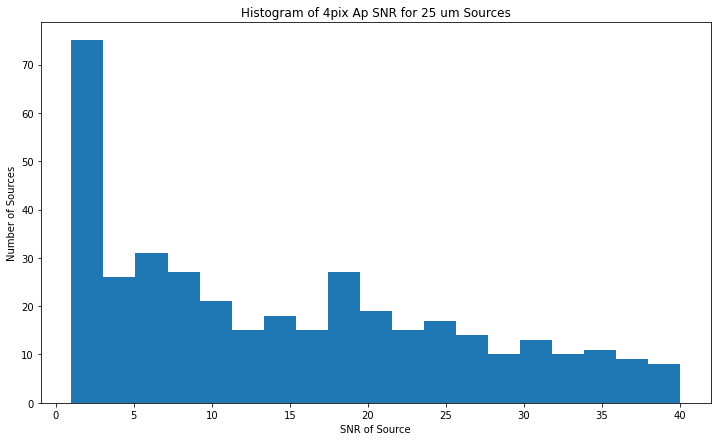

In [86]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 25 um Sources')
plt.hist(mastercat25['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [87]:
#lets examine SNR cuts...
snrcut4pix=mastercat25['aper_snr_4pix']>=3.0 #max snr in all computed apertures must be gtreq to 5
mcat25snrcut=mastercat25[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat25snrcut))

Number of Catalog Sources after SNR cut:  586


In [88]:
#other cuts to consider????

In [89]:
makeDS9file('mastercatComb_4pixSNRselect_25m_NoLabel.reg', mcat25snrcut, r, color='green')

In [90]:
#Optional - write 'master' catalogs to fits prior to quality cuts
mcat25snrcut.write('masterCat_25um_Step3.fits',overwrite=True)

## Repeat process for 37 um data

In [91]:
#create initial master catalog at 37 um
mastercat37=CombineFieldResults('CombCat',37)

#add names to mastercat
mastercat37=createNames(mastercat37)

#print the master catalog
mastercat37

type,old_id,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_5pix,aperture_sum_err_5pix,aperture_sum_6pix,aperture_sum_err_6pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_9pix,aperture_sum_err_9pix,aperture_sum_10pix,aperture_sum_err_10pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_5pix,aper_snr_5pix,aper_area_5pix,aper_sum_bkgsub_6pix,aper_snr_6pix,aper_area_6pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_8pix,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_9pix,aper_snr_9pix,aper_area_9pix,aper_sum_bkgsub_10pix,aper_snr_10pix,aper_area_10pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,RA(J2000),DEC(J2000),sky_centroid,id
,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,deg,deg,"deg,deg",
int32,int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
210,1,185.52670039804093,53.681509599399504,"266.32519212189436,-29.078043452495415",3.038125989040629,0.12873781395728318,3.8340316305974897,0.161356522678025,4.477400597525916,0.19411269396123848,5.062103517180406,0.22722886666884756,5.653787758181688,0.261084817763272,6.147162825172288,0.296144379491147,6.33818509769796,0.33286933090500737,6.279110303206851,0.4101161792889416,842.3889745012686,-0.008291028439998627,-0.00889312259081242,0.012207350368951642,400.12127685546875,316.49803944412605,3.474642923111335,51.56986939028689,52.6493109063293,4.516089340082968,67.72508788536295,82.26454829113952,5.459563699185005,82.0295005779659,118.46094953924091,6.398936627771943,96.2563860058174,161.2385146506335,7.399855494464513,111.6432819710594,210.5972436253172,8.357029803905238,126.20531308628505,266.53713646329203,9.066415935639872,136.09607948931605,329.0581931645581,10.207762709843205,150.62280089156164,473.84379815696366,FieldA,37,4.220584029567119,4.291791071036387,5.221517944580212,2.308550678153446,2.122284902105284,-6.703441583497326,266.32519212189436,-29.078043452495415,"266.32519212189436,-29.078043452495415",1
210,2,144.804629994082,245.1908047720209,"266.335129694411,-29.03718800477045",20.733919845616274,0.13056041380061684,29.72703908125696,0.16319050949682773,39.524833477108366,0.1958069342878246,50.13338759493407,0.2284116261425522,61.53797424628081,0.261046588976863,73.25382380933766,0.29370553579113085,85.09285222684386,0.32636011566354245,108.47124646492969,0.39160501600208275,842.3889745012686,0.06743507832288742,0.08319394071466124,0.05685508777456944,400.12127685546875,372.7514874228108,17.183509441001906,259.068344868191,52.6493109063293,24.179522824047012,374.5573003467291,82.26454829113952,31.53641006672604,496.5262971823095,118.46094953924091,39.26025573080257,625.1094205695497,161.2385146506335,47.33633262782334,760.0407031505348,210.5972436253172,55.27987113597742,892.3994219771456,266.53713646329203,62.90278719800406,1018.788902579486,329.0581931645581,76.5175528234004,1241.5432534655956,473.84379815696366,FieldA,37,3.76848349106858,3.665307040609574,5.739449085372184,2.5124297422148567,2.359820035729242,-16.04870762382659,266.335129694411,-29.03718800477045,"266.335129694411,-29.03718800477045",2
120,3,202.26413764277532,170.69592570159864,"266.3211082656507,-29.0530802215495",14.957998025410255,0.13232202151693315,22.635859125112216,0.1653965243486173,31.600788190153953,0

In [92]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat37.write('masterCatComb_FromFields_37um_NoCuts.fits',overwrite=True)

In [93]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('mastercatComb_37um_labelID.reg', mastercat37, r, color='yellow', labelon=True, label="id")
makeDS9file('mastercatComb_37um_label4pixSNR.reg', mastercat37, r, color='cyan', labelon=True, label="aper_snr_4pix")

In [94]:
#Now lets look at possible duplications that may exist because of overlapping data coverage

print('Number of sources with duplicates included', len(mastercat37))

mastercat37=remove_duplicates(mastercat37, 3.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 893
number of likely duplicates:  127


C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_15712/2402376784.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


Number of sources with duplicates removed 824


In [95]:
#write 'master' catalogs to fits - optional for testing
#mastercat37.write('masterCat_FromFields_noDuplicates_37um.fits',overwrite=True)

In [96]:
#write out save ds9 region files - optional for testing
makeDS9file('mastercat_noDuplicates_37um_labelID.reg', mastercat37, r, color='magenta', labelon=True, label="id")

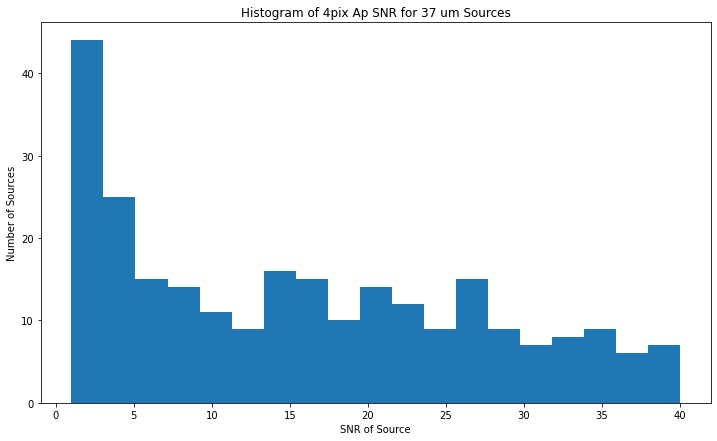

In [97]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 37 um Sources')
plt.hist(mastercat37['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [98]:
#lets examine SNR cuts...
snrcut4pix=mastercat37['aper_snr_4pix']>=3.0 #max snr in all computed apertures must be gtreq to 5
mcat37snrcut=mastercat37[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat37snrcut))

Number of Catalog Sources after SNR cut:  553


In [28]:
#more cuts to consider?

In [29]:
makeDS9file('mastercatComb_4pixSNRselect_37m_NoLabel.reg', mcat37snrcut, r, color='green')

In [30]:
#Optional - write 'master' catalogs to fits prior to quality cuts
mcat37snrcut.write('masterCat_37um_Step3.fits',overwrite=True)

## Crossmatch the 25 and 37 um catalogs

In [31]:
#get source coordinates from both tables
sources25=mcat25snrcut['sky_centroid']
sources37=mcat37snrcut['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = sources25.search_around_sky(sources37, 5*u.arcsec) #use larger search radius?
print('Number of crossmatched 25/37 sources found: ', len(idx))

Number of crossmatched 25/37 sources found:  857


In [32]:
matched25=mcat25snrcut[rdx]
matched37=mcat37snrcut[idx]

In [33]:
notrdx=findNOTindex(mcat25snrcut,rdx)
only25=mcat25snrcut[notrdx]

notidx=findNOTindex(mcat37snrcut,idx)
only37=mcat37snrcut[notidx]

In [34]:
t1=Table()
t1['RA(J2000)']=matched25['RA(J2000)']
t1['DEC(J2000)']=matched25['DEC(J2000)']
t1['25um Flux (Jy)']=matched25['aper_sum_bkgsub_4pix']
t1['fwhm25']=matched25['fwhm']
t1['25um SNR']=matched25['aper_snr_4pix']
t1['37um Flux (Jy)']=matched37['aper_sum_bkgsub_4pix']
t1['37um SNR']=matched37['aper_snr_4pix']
t1['fwhm37']=matched37['fwhm']


t2=Table()
t2['RA(J2000)']=only25['RA(J2000)']
t2['DEC(J2000)']=only25['DEC(J2000)']
t2['25um Flux (Jy)']=only25['aper_sum_bkgsub_4pix']
t2['25um SNR']=only25['aper_snr_4pix']
t2['fwhm25']=only25['fwhm']
t2['37um Flux (Jy)']=-1
t2['37um SNR']=-1
t2['fwhm37']=-1


t3=Table()
t3['RA(J2000)']=only37['RA(J2000)']
t3['DEC(J2000)']=only37['DEC(J2000)']
t3['25um Flux (Jy)']=-1
t3['25um SNR']=-1
t3['fwhm25']=-1
t3['37um Flux (Jy)']=only37['aper_sum_bkgsub_4pix']
t3['37um SNR']=only37['aper_snr_4pix']
t3['fwhm37']=only37['fwhm']

In [35]:
mastercat=vstack((t1,t2,t3))

In [36]:
#change format of columns to save fewer decimal places
for col in mastercat.colnames:
    if col!='RA(J2000)' and col!='DEC(J2000)' and col!='type': #skip columns that aren't relevant
        mastercat[col].info.format = '%.4G'

#display catalog
mastercat

RA(J2000),DEC(J2000),25um Flux (Jy),fwhm25,25um SNR,37um Flux (Jy),37um SNR,fwhm37
deg,deg,,pix,,,,pix
float64,float64,float64,float64,float64,float64,float64,float64
266.33591716284303,-29.037906320021353,19.06,5.873,348.9,15.98,271.5,5.78
266.3254722621009,-29.07789334142956,4.243,5.239,75.66,3.226,49.58,5.341
266.31859196098685,-29.057902466534006,4.229,5.669,70.18,6.248,100.3,5.694
266.31998201863314,-29.05390495647942,8.355,5.906,146.1,8.052,130.6,5.834
266.3362279098425,-29.038785430975665,12.45,5.751,226.6,11.1,184.4,5.717
266.33448072434913,-29.038787791948685,8.867,5.598,160,10.02,164.6,5.859
266.35377268616793,-29.055963810072285,1.6,5.758,19.96,1.126,9.995,5.751
266.3549333829732,-29.054051210496706,1.783,5.522,24.06,0.9815,6.991,5.635


In [37]:
#write out final catalog
mastercat.write('masterCat_step3_final.fits',overwrite=True)

## Optional - Create combined Segment Map Catalogs (mainly for testing purposes)

In [39]:
#create combined field segment map source catalog at 25 um
Segcat25=CombineFieldResults('segCat',25)

#Remove duplications from overlapping fields
SegCat25=remove_duplicates(Segcat25, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat25['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat25snr=SegCat25[snrcut4pix] #apply snr cut
print("Number of 25 um Seg Catalog Sources after SNR cut: ", len(Segcat25snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_25m_NoLabel.reg', Segcat25snr, r, color='green')

#write fits file
Segcat25snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_25392/2402376784.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


number of likely duplicates:  294
Number of 25 um Seg Catalog Sources after SNR cut:  858


In [40]:
Segcat25snr

old_id,xcentroid,ycentroid,background_centroid,background_mean,background_sum,area,semimajor_sigma_seg,semiminor_sigma_seg,orientation_seg,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm_seg,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,RA(J2000),DEC(J2000),sky_centroid,id,selfXmatch
,,,,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,deg,deg,"deg,deg",,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int32
1,185.74025305952063,45.29468593234474,-0.0010024959751888693,-0.0004956385032757274,-0.05005948883084846,101.0,2.6243450015424092,2.1592520002946807,6.6485615155907,0.14612593264096238,-0.01593585441761772,0.21355446379362664,0.5683636138426366,0.1772225073206377,1.2153954245193501,5.658813338648118,9.452813107528392,0.26268936835739903,2.275454410029209,5.635387378601118,0.10810196399688721,-0.0004975240031514727,-0.0005376331807221336,0.00013432667608972187,16.156001325545247,185.7402530596197,45.2946859322694,"266.3255679286236,-29.0777961489855",4.223261726128053,0.07965694794375933,6.990669465142625,0.13954518125803658,9.274056937915002,0.238326336657559,842.3889672608536,0.00015622811410386216,0.00040810074823285295,0.005793276622484106,419.3362724757975,336.2819897809317,4.215036423646986,75.11780662752693,52.64931045380335,6.96547947629436,123.6823749899232,161.2385132647728,9.200029215585404,159.73011029162714,473.84379408423024,FieldA,25,4.378306921607122,3.8199525587441663,5.1955358339515545,2.2621740636932857,2.149057712389039,11.862892326351194,266.3255679286236,-29.0777961489855,"266.3255679286236,-29.0777961489855",1,0
2,99.33997412427225,135.7560428642921,0.000645686407520613,0.01972296132447175,3.431795270458084,174.0,3.8835755737063407,3.2426723319262165,-1.7704318600475983,0.06633099263366786,0.0017786637010446392,0.09507543463733634,0.5502942012990037,0.1650291669664793,1.1976466248131257,8.42438032703874,--,--,nan,5.714359056859989,0.11486293375492096,0.019715966455985303,0.01957748140953601,0.0043672587653352255,6.10972394850931,99.33997412423895,135.75604286425096,"266.3466547631106,-29.058496515013818",2.2444751769657416,0.06317449923777498,5.263501701641234,0.11057385187481032,8.179289331002943,0.18959596849336177,842.3889672608536,-0.0022032085635257017,-0.0024315801082415126,0.006543116118794441,477.7574157714844,476.9713757719391,2.3604725886212847,38.64366558564773,52.64931045380335,5.618743774836334,96.69975751476773,161.2385132647728,9.223266035902828,157.8522858399414,473.84379408423024,FieldA,25,3.832897264201368,4.41238741642627,5.783185493264922,2.4629032764829675,2.44886216866295,-45.987069195414584,266.3466547631106,-29.058496515013818,"266.3466547631106,-29.058496515013818",2,0
3,83.94487721758777,159.5619761735801,0.0009578778421280461,0.03018293132272653,2.8371955443362937,94.0,2.9415442293194145,2.491499368532639,85.1490718882491,0.16076812412716185,-0.007671521450482014,0.11589662823547614,0.5315867109270886,0.15299612234316196,1.1806321392133556,6.418829011

In [41]:
#create combined field segment map source catalog at 37 um
Segcat37=CombineFieldResults('segCat',37)

#Remove duplications from overlapping fields
SegCat37=remove_duplicates(Segcat37, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat37['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat37snr=SegCat37[snrcut4pix] #apply snr cut
print("Number of 37 um Seg Catalog Sources after SNR cut: ", len(Segcat37snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_37m_NoLabel.reg', Segcat37snr, r, color='green')

#write fits file
Segcat37snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

C:\Users\MHANKI~1\AppData\Local\Temp/ipykernel_25392/2402376784.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matchstore=np.zeros(len(cat),dtype=np.int)


number of likely duplicates:  282
Number of 37 um Seg Catalog Sources after SNR cut:  920


In [42]:
Segcat37snr

old_id,xcentroid,ycentroid,background_centroid,background_mean,background_sum,area,semimajor_sigma_seg,semiminor_sigma_seg,orientation_seg,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm_seg,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_7pix,aperture_sum_err_7pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_7pix,aper_snr_7pix,aper_area_7pix,aper_sum_bkgsub_12pix,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,RA(J2000),DEC(J2000),sky_centroid,id,selfXmatch
,,,,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,deg,deg,"deg,deg",,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int32
1,165.88124869656778,135.1457600413451,0.105157953693618,0.08381862214796677,0.6705489771837342,8.0,0.8769722412230371,0.6688080918264174,43.894949188395,1.7498989131658533,-0.9346646218817445,1.7859701379371873,0.6468312744319636,0.2373668624976215,1.3112464576021408,1.836446066762363,3.0502143518220093,0.218849915392413,3.5576433313609304,0.3180231434827696,0.05132055655121803,0.08380100852482836,0.08372312982837603,0.0017530802984467436,1.2440902422001605,165.88124869667803,135.14576004139107,"266.32998730132323,-29.06066444114748",1.4361474202736453,0.13156885091446782,3.4240688268525985,0.2301722297471936,6.334599409822843,0.39444305527428686,842.3886494273573,-0.0004895834732235229,-0.0014007875371557087,0.015934638470782567,400.12127685546875,399.28152922907714,1.461923642823065,11.841245627924435,52.649290589209805,3.503008508410197,35.623862346703916,161.23845242945507,6.566585412767622,70.69985509181079,473.8436153028882,FieldA,37,4.6615991348491255,4.509769738878789,5.350586354743857,2.3200332857300094,2.223306826488856,47.27429070714086,266.32998730132323,-29.06066444114748,"266.32998730132323,-29.06066444114748",1,0
2,167.721005456061,139.46752245357496,0.10689638267581611,0.09481086211696702,0.6636760348187691,7.0,1.2340198435091818,0.5847190899471192,-21.821246697740367,0.970077048804135,1.5653987412335955,2.61146835817579,0.8806148239969739,0.5261671900798988,2.1104490424979696,2.273774403851281,3.4409512080472973,0.24859120479955898,3.6420654056456057,0.2440112566841834,0.04795633628964424,0.09331031030341473,0.09330699734645656,0.002666071464332059,0.9453907304634207,167.72100545600614,139.46752245360557,"266.3295382816666,-29.05974246988601",1.5821418218562586,0.13160807260993931,3.6855860075505813,0.23030600062649667,5.754407922891304,0.39480453920049835,842.3886494273573,-0.0003286288233462775,-0.0012227842082075061,0.01675698505552631,400.12127685546875,399.59329539155095,1.599443896272607,13.359639770918713,52.649290589209805,3.738573610450648,38.38912912650552,161.23845242945507,5.910126592638439,57.47936235547718,473.8436153028882,FieldA,37,4.172936348945814,3.6415464483904443,5.739674384677733,2.550069670800815,2.3192954259942944,58.439418286752016,266.3295382816666,-29.05974246988601,"266.3295382816666,-29.05974246988601",2,0
3,67.73793200190819,155.70307950024414,-0.004177105834915287,0.05753259209647462,0.2876629604823731,5.0,1.1947068696746086,0.28650901315579624,-34.92444736022005,4.463697121268363,10.778709370165084,8.41904981103734,0.9708185263629986,0.760184677573813

## testing...

In [66]:
np.max(Segcat25['fwhm'])

6.0680694089549565

In [67]:
np.min(Segcat25['fwhm'])

3.0486507818268596

In [68]:
np.mean(Segcat25['fwhm'])

5.457743928773992

In [69]:
np.std(Segcat25['fwhm'])

0.42717443772804187

In [70]:
np.mean(Segcat25['fwhm_seg'])

4.871949935807235

In [71]:
np.std(Segcat25['fwhm_seg'])

2.880269379660212

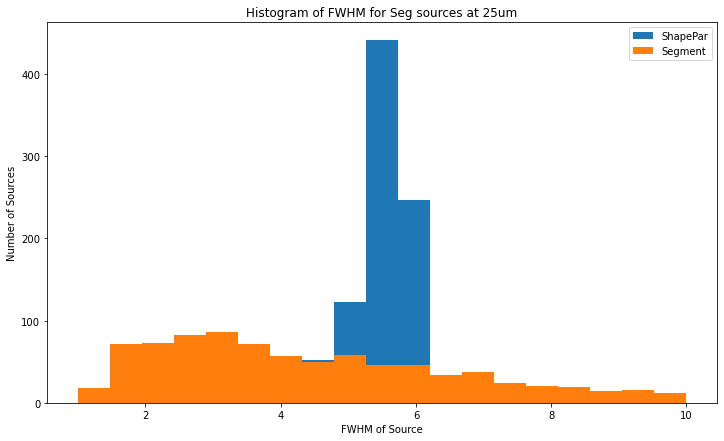

In [45]:
#now lets look at SNR distrobution
binlist=np.linspace(1,10,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of FWHM for Seg sources at 25um')
plt.hist(Segcat25['fwhm'],bins=binlist,label='ShapePar')
plt.hist(Segcat25['fwhm_seg'],bins=binlist,label='Segment')
plt.legend()
plt.xlabel('FWHM of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [46]:
xmatch=mcat25snrcut['type']=='C'
segonly=mcat25snrcut['type']=='S'
daoonly=mcat25snrcut['type']=='D'

In [47]:
xmatch25=mcat25snrcut[xmatch]
seg25=mcat25snrcut[segonly]
dao25=mcat25snrcut[daoonly]

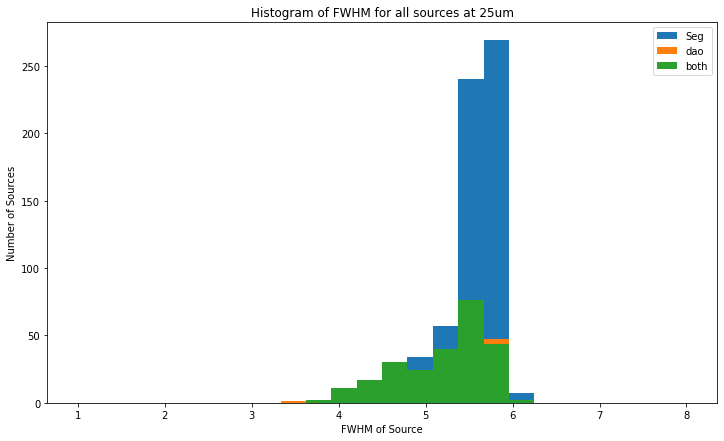

In [48]:
#now lets look at SNR distrobution
binlist=np.linspace(1,8,25)

plt.figure(figsize=(12,7))
plt.title('Histogram of FWHM for all sources at 25um')
plt.hist(seg25['fwhm'],bins=binlist,label='Seg')
plt.hist(dao25['fwhm'],bins=binlist,label='dao')
plt.hist(xmatch25['fwhm'],bins=binlist,label='both')
plt.legend()
plt.xlabel('FWHM of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()